# Representation Learning

In [39]:
import numpy as np
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image
from scipy import misc
import matplotlib.image as mpimg

In [40]:
def load_faces(data_path):
    data = dict()
    for i in range(1, 41):
        images = list()
        for j in range(1, 11):
            path = data_path + 's' + str(i) + '/' + str(j) + '.pgm'
            images.append(mpimg.imread(path))
        data[i] = images
    return data

In [41]:
data = load_faces('orl_faces/')

In [42]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

# Simple Auto-Encoder

In [43]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [44]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [45]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [46]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [47]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [49]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


In [50]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.3627 - val_loss: 0.2712
Epoch 2/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.2640 - val_loss: 0.2532
Epoch 3/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.2421 - val_loss: 0.2288
Epoch 4/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.2210 - val_loss: 0.2112
Epoch 5/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.2064 - val_loss: 0.1989
Epoch 6/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.1956 - val_loss: 0.1894
Epoch 7/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.1871 - val_loss: 0.1820
Epoch 8/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.1804 - val_loss: 0.1758
Epoch 9/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.1746 - val_loss: 0.1708
Epoch

In [51]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

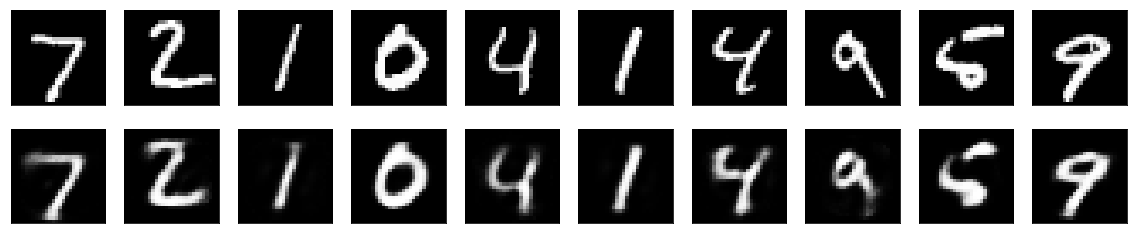

In [67]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Sparse Auto-Encoder

In [77]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
sencoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
sdecoded = Dense(784, activation='sigmoid')(sencoded)

sparseautoencoder = Model(input_img, sdecoded)

sencoder = Model(input_img, sencoded)
# create a placeholder for an encoded (32-dimensional) input
sencoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
sdecoder_layer = sparseautoencoder.layers[-1]
# create the decoder model
sdecoder = Model(sencoded_input, sdecoder_layer(sencoded_input))

In [78]:
sparseautoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
sparseautoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.6734 - val_loss: 0.6485
Epoch 2/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.6284 - val_loss: 0.6090
Epoch 3/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.5916 - val_loss: 0.5749
Epoch 4/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.5598 - val_loss: 0.5454
Epoch 5/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.5323 - val_loss: 0.5198
Epoch 6/50
60000/60000 [==============================] - 2s 42us/step - loss: 0.5084 - val_loss: 0.4975
Epoch 7/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.4875 - val_loss: 0.4780
Epoch 8/50
60000/60000 [==============================] - 2s 42us/step - loss: 0.4692 - val_loss: 0.4609
Epoch 9/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.4531 - val_loss: 0.4457
Epoch

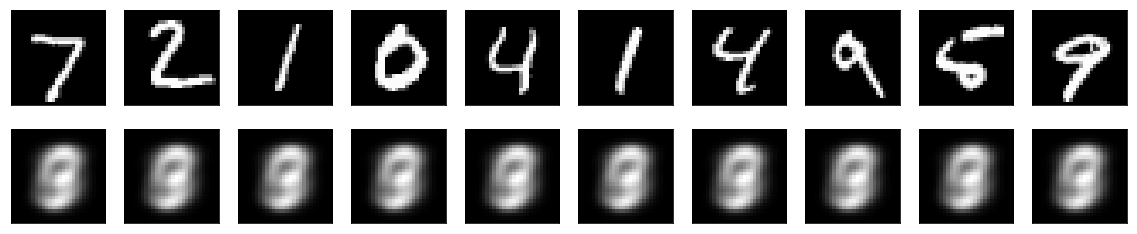

In [80]:

# encode and decode some digits
# note that we take them from the *test* set
sencoded_imgs = sencoder.predict(x_test)
sdecoded_imgs = sdecoder.predict(sencoded_imgs)
# use Matplotlib (don' ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(sdecoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()